# File for training sign language model.
# Use pickle.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

import matplotlib.pyplot as plt


2023-03-29 17:58:52.508347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 17:58:52.587941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 17:58:52.588946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 17:58:53.896469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%run data.ipynb

Folders =  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Dataset Loaded
Dataset Folder =  Dataset/Indian/
The shape of Images is: (42000, 64, 64)
The shape of Labels is: (42000,)


In [3]:
# Unrolling the 2d matrix (64, 64) to (64 * 64, ) 1d matrix

def unroll_matrix():
    n = images.shape[0]
    t = tuple(images[i].ravel() for i in range(n))
    return np.array(t)


def encoder(label):
    if label <= '9':
        return ord(label) - 48
    return ord(label) - 55


def encode_labels():
    t = tuple(encoder(label) for label in labels)
    return np.array(t)


In [4]:
images   = unroll_matrix()
y_labels = encode_labels()

print("New shape = ", images.shape)


New shape =  (42000, 4096)


In [5]:
# Setting up the model parameters


tf.random.set_seed(1234) # for consistent results

model = Sequential(
    [               
        tf.keras.Input(shape=(4096, )),  # To be adjusted for inputs
        Dense(60, activation='relu'),
        Dense(45, activation='relu'),
        Dense(36, activation='linear')

    ], name = "sign_recognition_model" 
)


model.summary()


Model: "sign_recognition_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                245820    
                                                                 
 dense_1 (Dense)             (None, 45)                2745      
                                                                 
 dense_2 (Dense)             (None, 36)                1656      
                                                                 
Total params: 250,221
Trainable params: 250,221
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compiling and training the model

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    images, y_labels,
    epochs=10
)

model.save('isl_model.h5')

Epoch 1/10


2023-03-29 17:59:10.661583: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172032000 exceeds 10% of free system memory.


1313/1313 [==============================] - 10s 7ms/step - loss: 1.2596
Epoch 2/10
1313/1313 [==============================] - 8s 6ms/step - loss: 0.1462
Epoch 3/10
1313/1313 [==============================] - 8s 6ms/step - loss: 0.1332
Epoch 4/10
1313/1313 [==============================] - 8s 6ms/step - loss: 1.4453e-04
Epoch 5/10
1313/1313 [==============================] - 8s 6ms/step - loss: 5.2894e-08
Epoch 6/10
1313/1313 [==============================] - 8s 6ms/step - loss: 2.6455e-08
Epoch 7/10
1313/1313 [==============================] - 8s 6ms/step - loss: 1.5684e-08
Epoch 8/10
1313/1313 [==============================] - 8s 6ms/step - loss: 9.8517e-09
Epoch 9/10
1313/1313 [==============================] - 8s 6ms/step - loss: 6.2953e-09
Epoch 10/10
1313/1313 [==============================] - 8s 6ms/step - loss: 3.9254e-09


1/1 [==============================] - 0s 24ms/step


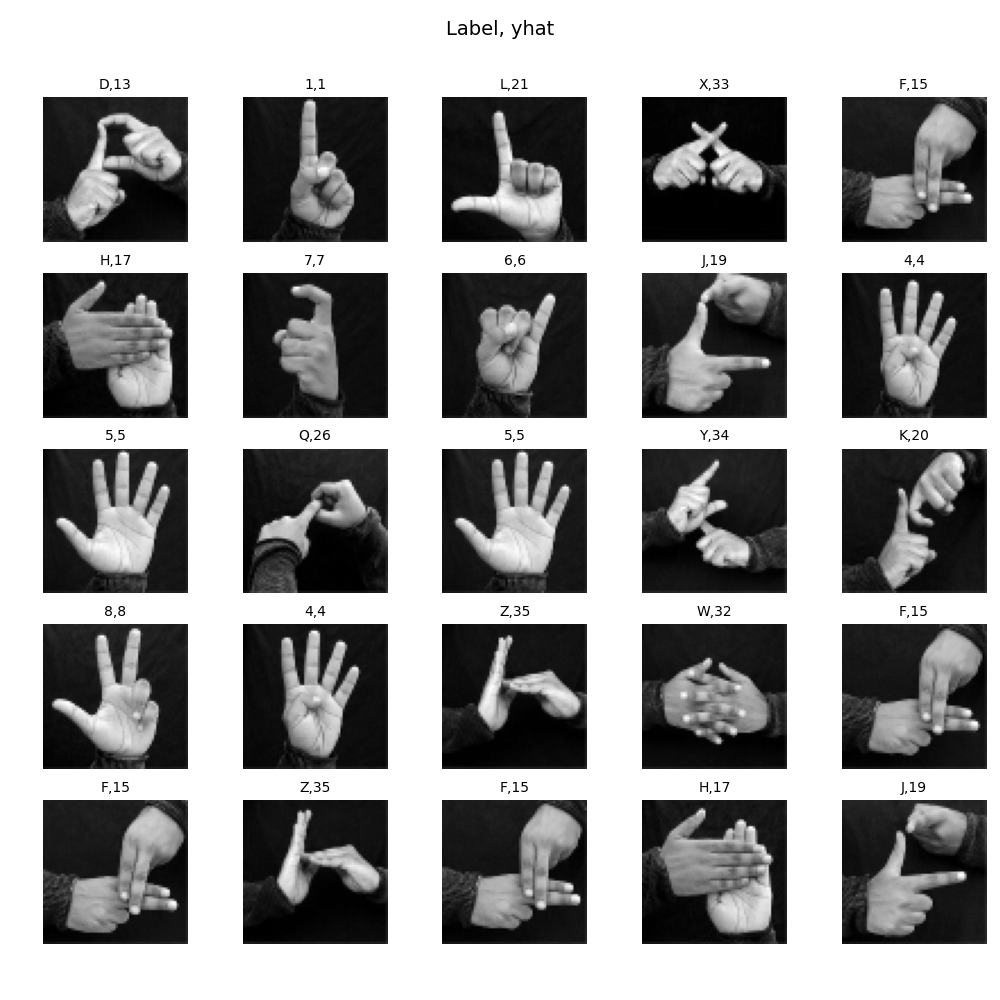

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = images.shape

fig, axes = plt.subplots(5, 5, figsize=(10,10))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = images[random_index].reshape(64, 64)
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(images[random_index].reshape(1,4096))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)

    # Display the label above the image
    ax.set_title(f"{labels[random_index]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()